# 6.6 Sourcing & Analyzing Time-Series Data

# Contents
1. Importing libraries  
2. Importing data
3. Subsetting, wrangling, and cleaning time-series data
4. Time series analysis: decomposition
5. Testing for stationarity
6. Stationarizing the Federal Reserve Economic Data

# 1. Importing Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = '3WKBSgsHLdh4U8W19jad'

# 2. Importing Data

In [3]:
# Importing Bombay Stock Exchange Data "BSE SENSEX 50"

data = quandl.get('BSE/SPBSS5IP')

In [4]:
# Exploring Data
data.head()

,Open,High,Low,Close
Date,,,,
2017-09-19,10585.14,10585.88,10535.06,10551.47
2017-09-20,10572.58,10579.76,10537.31,10542.20
2017-09-21,10544.30,10562.01,10460.29,10520.62
2017-09-22,10507.69,10508.40,10351.80,10361.97
2017-09-25,10380.50,10388.43,10215.60,10261.82


In [5]:
data.shape

(970, 4)

In [6]:
data.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [7]:
# Check data type
type(data)

pandas.core.frame.DataFrame

In [8]:
# We will consider only one column for time series analysis
data_TS = data[['Close']]

In [9]:
data_TS.head()

,Close
Date,
2017-09-19,10551.47
2017-09-20,10542.20
2017-09-21,10520.62
2017-09-22,10361.97
2017-09-25,10261.82


In [10]:
data_TS.dtypes

Close    float64
dtype: object

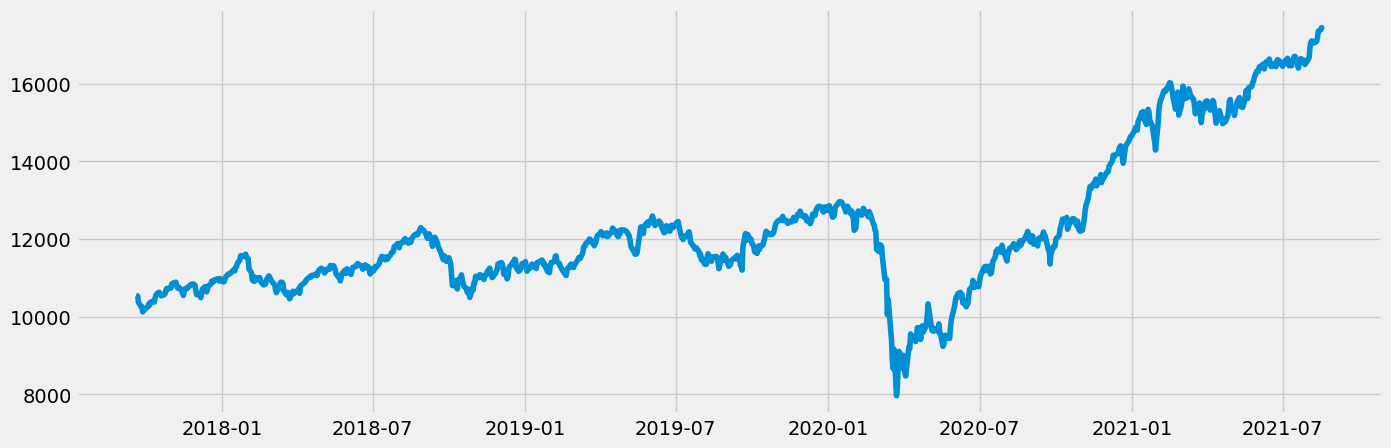

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data_TS)

# 3. Subsetting, wrangling, and cleaning time-series data

In [12]:
# Check for missing values

data_TS.isnull().sum() 

Close    0
dtype: int64

No missing values found

In [13]:
dups = data_TS.duplicated()

In [14]:
dups.shape

(970,)

No duplicates found

# 4. Time-series analysis: decomposition

In [15]:
# Decompose time series using multiplicative model
decomposition = sm.tsa.seasonal_decompose(data_TS, model='multiplicative', freq=30)

In [16]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

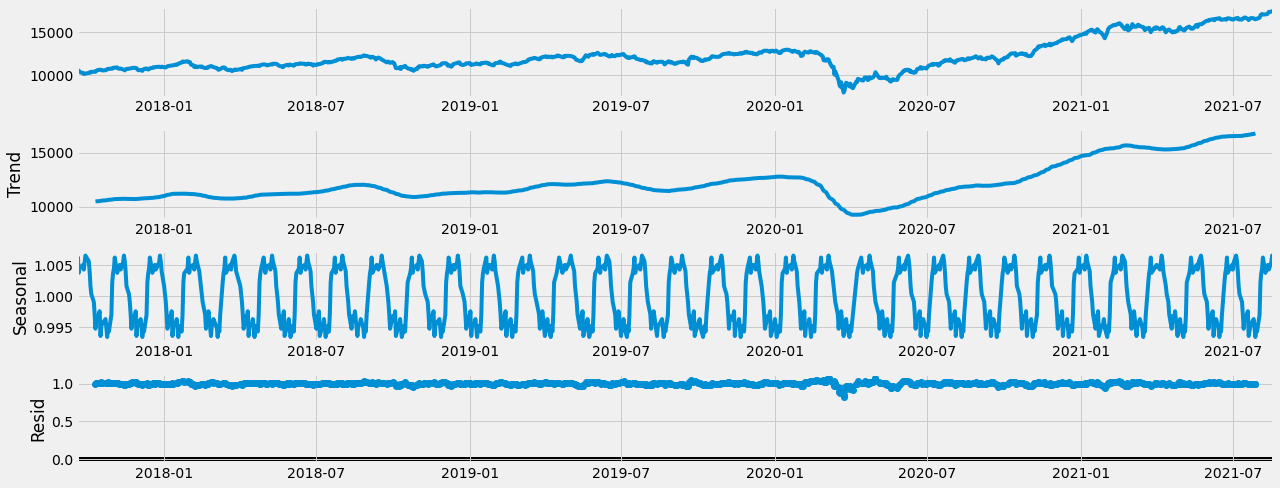

In [17]:
# Plot the separate components

decomposition.plot()
plt.show()

1. The trend, seasonality, and noise have all been charted here beneath the original data, or level. We can see the trend is smoothed out as compared to level. But the pattern in both, the trend and level is same. From Jan 2018 till July 2021, We can see that trend has been decreased drastically in April 2020. This is due to the corona pandemic happened during that same period of time and then it again started increasing from July 2020. It is still going upward.
2. The seasonality component displays fluctuations indicating season fluctuations at a regular interval.
3. The residual i.e. noise shows that there isn't too much unexplained noise with a few deviations around April 2020 which represent downward trends on the line chart.


# 5. Testing for stationarity

In [19]:
# Import adfuller() function, perform Dickey-Fuller Test, and apply test using function on time series

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_TS['Close'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.042591
p-value                          0.954865
Number of Lags Used             11.000000
Number of Observations Used    958.000000
Critical Value (1%)             -3.437194
Critical Value (5%)             -2.864562
Critical Value (10%)            -2.568379
dtype: float64


Since the p-value(0.95) is not less than 0.05, the result is not significant. Using the critical value (5%) which is -2.8, it is much smaller than the test statistic value (-0.042)). This means you cannot reject the null hypothesis. This indicates that there is a unit root in the data and that the data is likely non-stationary.

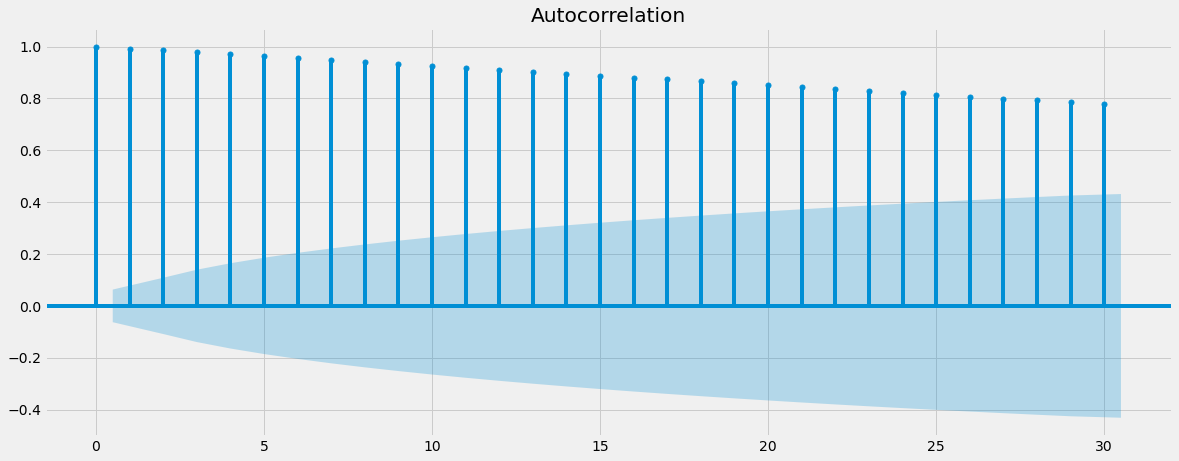

In [20]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_TS)
plt.show()

Above time series for BSE SENSEX 50 has quite a few lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test you conducted earlier.

# 5.Stationarizing the BSE SENSEX 50 Data

In [21]:
data_diff = data_TS - data_TS.shift(1) 

In [22]:
#remove the missing values that came about as a result of the differencing. 
data_diff.dropna(inplace = True) 

In [23]:
data_diff.head()

,Close
Date,
2017-09-20,-9.27
2017-09-21,-21.58
2017-09-22,-158.65
2017-09-25,-100.15
2017-09-26,-5.59


In [24]:
data_diff.columns

Index(['Close'], dtype='object')

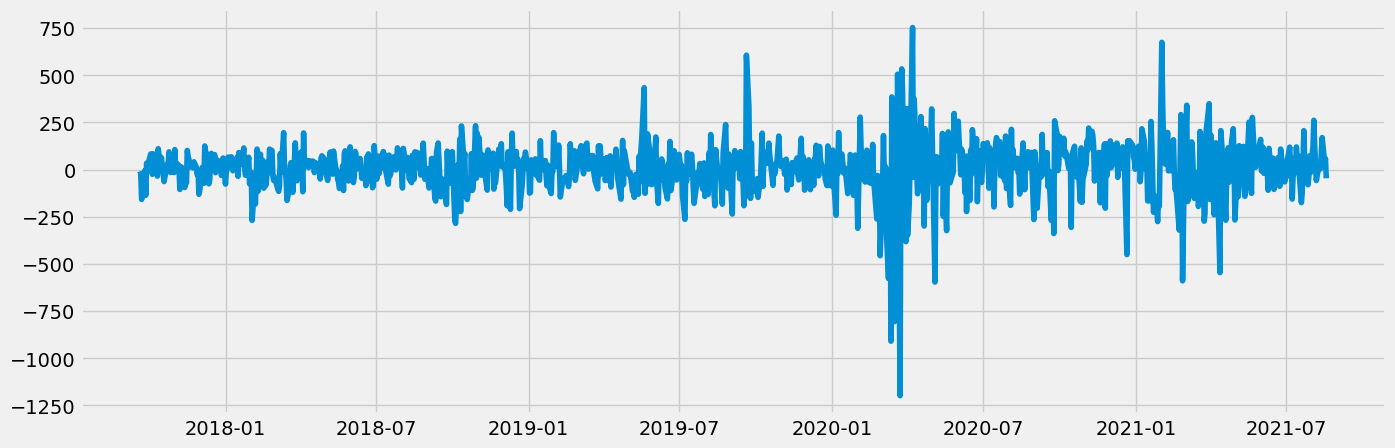

In [25]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
# Perform Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.691504e+00
p-value                        4.028989e-14
Number of Lags Used            1.000000e+01
Number of Observations Used    9.580000e+02
Critical Value (1%)           -3.437194e+00
Critical Value (5%)           -2.864562e+00
Critical Value (10%)          -2.568379e+00
dtype: float64


Now the p-value is much less than 0.05, the result is significant and the critical value (5%) which is -2.8 is much greater than the test statistic value (-8.69)). This means you can reject the null hypothesis and the series is now stationary.

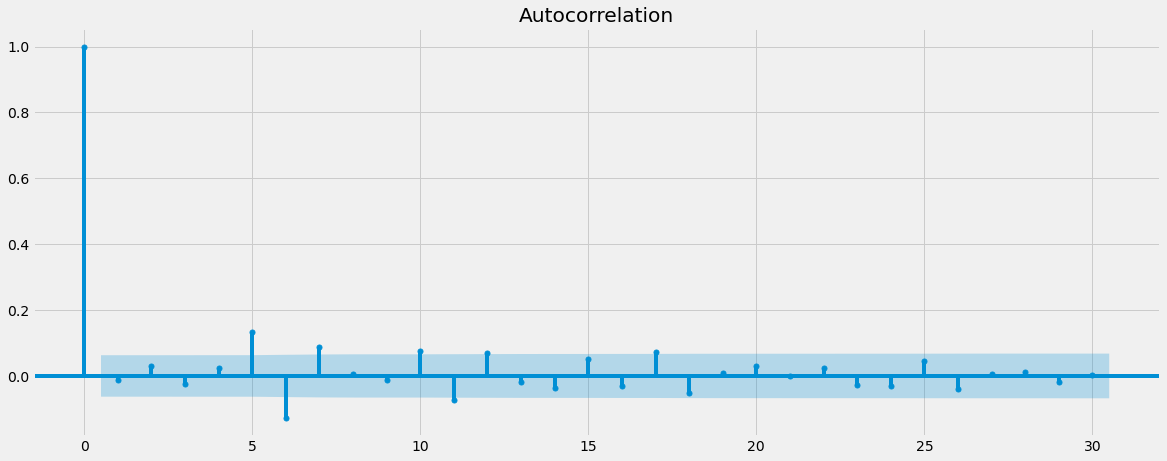

In [27]:
plot_acf(data_diff)
plt.show()

 the autocorrelation plot has improved.However there are still lags outside of the confidence interval and it indicates a weak stationarity. Since there are less than 10 significant lags, a second round of differencing is not necessary.